<a href="https://colab.research.google.com/github/koji/AI-Colab-Notebooks/blob/main/Wan2_1_T2I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup env
%cd /content
!git clone https://github.com/comfyanonymous/ComfyUI /content/ComfyUI
!git clone https://github.com/city96/ComfyUI-GGUF /content/ComfyUI/custom_nodes/ComfyUI-GGUF
!pip install torchsde gguf av

/content
Cloning into '/content/ComfyUI'...
remote: Enumerating objects: 25235, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 25235 (delta 0), reused 0 (delta 0), pack-reused 25230 (from 2)
Receiving objects: 100% (25235/25235), 67.14 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (17045/17045), done.
Cloning into '/content/ComfyUI/custom_nodes/ComfyUI-GGUF'...
remote: Enumerating objects: 702, done.
remote: Counting objects: 100% (354/354), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 702 (delta 315), reused 199 (delta 193), pack-reused 348 (from 2)
Receiving objects: 100% (702/702), 194.75 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (457/457), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 7.0 MB/s eta 0:00:00


In [2]:
!apt install aria2 -qqy

The following additional packages will be installed:
  libaria2-0 libc-ares2
The following NEW packages will be installed:
  aria2 libaria2-0 libc-ares2
0 upgraded, 3 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,513 kB of archives.
After this operation, 5,441 kB of additional disk space will be used.
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 126441 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) 

In [4]:
# download models
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/city96/Wan2.1-T2V-14B-gguf/resolve/main/wan2.1-t2v-14b-Q3_K_S.gguf -d /content/ComfyUI/models/unet -o wan2.1-t2v-14b-Q3_K_M.gguf
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/city96/umt5-xxl-encoder-gguf/resolve/main/umt5-xxl-encoder-Q3_K_S.gguf -d /content/ComfyUI/models/clip -o umt5-xxl-encoder-Q3_K_M.gguf
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/Comfy-Org/Wan_2.1_ComfyUI_repackaged/resolve/main/split_files/vae/wan_2.1_vae.safetensors -d /content/ComfyUI/models/vae -o/wan_2.1_vae.safetensors
!aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/vrgamedevgirl84/Wan14BT2VFusioniX/resolve/main/FusionX_LoRa/Wan2.1_T2V_14B_FusionX_LoRA.safetensors -d /content/ComfyUI/models/loras/FusionX -o Wan2.1_T2V_14B_FusionX_LoRA.safetensors



Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
4f8c42|OK  |   145MiB/s|/content/ComfyUI/models/unet/wan2.1-t2v-14b-Q3_K_M.gguf

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
7a5eaf|OK  |   154MiB/s|/content/ComfyUI/models/clip/umt5-xxl-encoder-Q3_K_M.gguf

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
ccf615|OK  |   299MiB/s|/content/ComfyUI/models/vae//wan_2.1_vae.safetensors

Status Legend:
(OK):download completed.

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
d35d9e|OK  |   255MiB/s|/content/ComfyUI/models/loras/FusionX/Wan2.1_T2V_14B_FusionX_LoRA.safetensors

Status 

In [6]:
%cd /content/ComfyUI

/content/ComfyUI


In [7]:
import torch
import random, time
from PIL import Image
import numpy as np

from nodes import NODE_CLASS_MAPPINGS
from comfy_extras import nodes_hunyuan, nodes_model_advanced

In [8]:
import sys
import os
sys.path.append("/content/ComfyUI/custom_nodes/ComfyUI-GGUF")

try:
    import importlib.util
    spec = importlib.util.spec_from_file_location("comfyui_gguf", "/content/ComfyUI/custom_nodes/ComfyUI-GGUF/__init__.py")
    comfyui_gguf = importlib.util.module_from_spec(spec)
    sys.modules["comfyui_gguf"] = comfyui_gguf
    spec.loader.exec_module(comfyui_gguf)

    if hasattr(comfyui_gguf, 'NODE_CLASS_MAPPINGS'):
        NODE_CLASS_MAPPINGS.update(comfyui_gguf.NODE_CLASS_MAPPINGS)
        print("ComfyUI-GGUF nodes loaded successfully!")

except Exception as e:
    print(f"Error loading ComfyUI-GGUF: {e}")

ComfyUI-GGUF nodes loaded successfully!


In [9]:
gguf_nodes = [k for k in NODE_CLASS_MAPPINGS.keys() if "GGUF" in k]
print(f"Available GGUF nodes: {gguf_nodes}")

required_nodes = ["UnetLoaderGGUF", "CLIPLoaderGGUF", "LoraLoaderModelOnly", "VAELoader"]
missing_nodes = [node for node in required_nodes if node not in NODE_CLASS_MAPPINGS]

if missing_nodes:
    print(f"Missing nodes: {missing_nodes}")
    print("Available nodes:", list(NODE_CLASS_MAPPINGS.keys())[:20])
else:
    UnetLoaderGGUF = NODE_CLASS_MAPPINGS["UnetLoaderGGUF"]()
    CLIPLoaderGGUF = NODE_CLASS_MAPPINGS["CLIPLoaderGGUF"]()
    LoraLoaderModelOnly = NODE_CLASS_MAPPINGS["LoraLoaderModelOnly"]()
    VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()

    CLIPTextEncode = NODE_CLASS_MAPPINGS["CLIPTextEncode"]()
    EmptyHunyuanLatentVideo = nodes_hunyuan.NODE_CLASS_MAPPINGS["EmptyHunyuanLatentVideo"]()

    KSampler = NODE_CLASS_MAPPINGS["KSampler"]()
    ModelSamplingSD3 = nodes_model_advanced.NODE_CLASS_MAPPINGS["ModelSamplingSD3"]()
    VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()

    print("All required nodes loaded successfully!")

Available GGUF nodes: ['UnetLoaderGGUF', 'CLIPLoaderGGUF', 'DualCLIPLoaderGGUF', 'TripleCLIPLoaderGGUF', 'QuadrupleCLIPLoaderGGUF', 'UnetLoaderGGUFAdvanced']
All required nodes loaded successfully!


In [11]:
    model_paths = {
        "unet": "/content/ComfyUI/models/unet/wan2.1-t2v-14b-Q3_K_M.gguf",
        "clip": "/content/ComfyUI/models/clip/umt5-xxl-encoder-Q3_K_M.gguf",
        "vae": "/content/ComfyUI/models/vae/wan_2.1_vae.safetensors",
        "lora": "/content/ComfyUI/models/loras/FusionX/Wan2.1_T2V_14B_FusionX_LoRA.safetensors"
    }

    print("\nModel file check:")
    for model_type, path in model_paths.items():
        exists = os.path.exists(path)
        print(f"{model_type}: {'✓' if exists else '✗'} {path}")

    try:
        with torch.inference_mode():
            print("\nLoading models...")

            unet = UnetLoaderGGUF.load_unet("wan2.1-t2v-14b-Q3_K_M.gguf")[0]
            print("✓ UNet loaded")

            clip = CLIPLoaderGGUF.load_clip("umt5-xxl-encoder-Q3_K_M.gguf", "wan")[0]
            print("✓ CLIP loaded")

            lora = LoraLoaderModelOnly.load_lora_model_only(unet, "FusionX/Wan2.1_T2V_14B_FusionX_LoRA.safetensors", 1.0)[0]
            print("✓ LoRA loaded")

            vae = VAELoader.load_vae("wan_2.1_vae.safetensors")[0]
            print("✓ VAE loaded")

            print("\n&#x1f389; All models loaded successfully!")

    except Exception as e:
        print(f"\n&#x274c; Error loading models: {e}")


Model file check:
unet: ✓ /content/ComfyUI/models/unet/wan2.1-t2v-14b-Q3_K_M.gguf
clip: ✓ /content/ComfyUI/models/clip/umt5-xxl-encoder-Q3_K_M.gguf
vae: ✓ /content/ComfyUI/models/vae/wan_2.1_vae.safetensors
lora: ✓ /content/ComfyUI/models/loras/FusionX/Wan2.1_T2V_14B_FusionX_LoRA.safetensors

Loading models...
✓ UNet loaded


✓ CLIP loaded
✓ LoRA loaded
✓ VAE loaded

&#x1f389; All models loaded successfully!


In [12]:
def generate_image(positive_prompt, negative_prompt,
                  seed=0, steps=10, cfg=1.0,
                  sampler_name="euler", scheduler="beta",
                  width=1280, height=720, length=1,
                  output_path="/content/test.png"):
    """
    High-Quality Character Image Generation Function

    Parameters:
    -----------
    positive_prompt : str
        Positive prompt (detailed description of desired content)
    negative_prompt : str
        Negative prompt (specification of elements to avoid)
    seed : int
        Random seed (0 for random generation)
    steps : int
        Number of sampling steps (affects image quality)
    cfg : float
        CFG value (prompt adherence strength)
    sampler_name : str
        Name of the sampler
    scheduler : str
        Name of the scheduler
    width, height : int
        Output image dimensions
    length : int
        Parameter for video generation (set to 1 for still images)
    output_path : str
        Path to save the generated image

    Returns:
    --------
    PIL.Image
        The generated image object
    """

    with torch.inference_mode():
        positive_encoded = CLIPTextEncode.encode(clip, positive_prompt)[0]
        negative_encoded = CLIPTextEncode.encode(clip, negative_prompt)[0]

        model_configured = ModelSamplingSD3.patch(lora, 1.0)[0]
        latent_space = EmptyHunyuanLatentVideo.generate(width, height, length)[0]

        if seed == 0:
            random.seed(int(time.time()))
            seed = random.randint(0, 18446744073709551615)

        print(f"🎲 Seed used: {seed}")

        samples = KSampler.sample(
            model_configured, seed, steps, cfg,
            sampler_name, scheduler,
            positive_encoded, negative_encoded, latent_space
        )[0]

        decoded = VAEDecode.decode(vae, samples)[0].detach()
        image_array = np.array(decoded * 255, dtype=np.uint8)[0]
        final_image = Image.fromarray(image_array)

        if output_path:
            final_image.save(output_path)
            print(f"💾 Image saved to: {output_path}")

        return final_image


🎲 Seed used: 8778260507413966823


  0%|          | 0/10 [00:00<?, ?it/s]

💾 Image saved to: /content/test.png


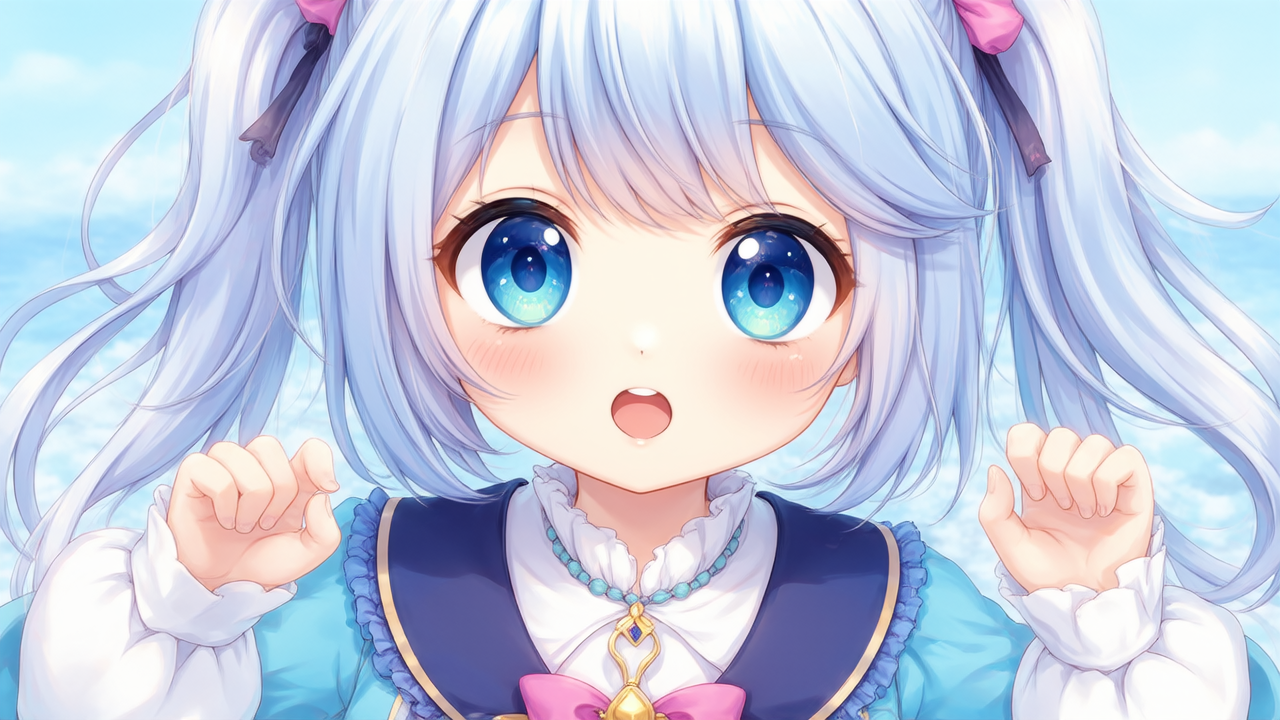

In [15]:
positive_test_prompt = """
Adorable chibi anime character, big sparkling eyes, small body proportions, round face, soft pastel colors, kawaii expression, detailed outfit with ribbons and accessories, clean line art, vibrant shading, highly detailed, cute pose, cheerful and playful atmosphere, studio-quality illustration
"""

negative_test_prompt = """
Realistic proportions, scary, creepy, ugly, deformed, extra limbs, blurry, low resolution, messy background, dark horror style, grotesque, overly sexualized, distorted anatomy, bad hands, bad face, text, watermark
"""

test_image = generate_image(
    positive_test_prompt,
    negative_test_prompt,
    output_path="/content/test.png"
)

display(test_image)